# 1. Library Imports and Installing Dependencies

### 1.1 Install Dependencies

In [6]:
%pip install -q labelme bs4 tensorflow opencv-python matplotlib albumentations scikit-learn

Note: you may need to restart the kernel to use updated packages.


### 1.2 Library Imports

In [1]:
import os
import time
import uuid
import requests
from bs4 import BeautifulSoup
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.losses import SparseCategoricalCrossentropy
import albumentations as alb
from sklearn.model_selection import train_test_split

### 1.3 Limit GPU Memory Growth

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2. Dataset

### 2.1 Directory Config

In [4]:
# Define character classes
CHARACTER_CLASSES = {
    "sheldon": 0,
    "leonard": 1,
    "penny": 2,
    "howard": 3,
    "raj": 4,
    "amy": 5,
    "bernadette": 6
}
CHARACTER_NAMES = {v: k for k, v in CHARACTER_CLASSES.items()}  # Reverse mapping

# Define paths
IMG_DIR = "data/images"
LABELS_DIR = "data/labels"
TRAIN_IMAGES_DIR = os.path.join("data", "train", "images")
TRAIN_LABELS_DIR = os.path.join("data", "train", "labels")
VALIDATION_IMAGES_DIR = os.path.join("data", "validation", "images")
VALIDATION_LABELS_DIR = os.path.join("data", "validation", "labels")
TEST_IMAGES_DIR = os.path.join("data", "test", "images")
TEST_LABELS_DIR = os.path.join("data", "test", "labels")


# Define agumentation paths
AUG_DATA_DIR = "aug_data"
TRAIN_AUG_IMAGES_DIR = os.path.join(AUG_DATA_DIR, "train", "images")
TRAIN_AUG_LABELS_DIR = os.path.join(AUG_DATA_DIR, "train", "labels")
VALIDATION_AUG_IMAGES_DIR = os.path.join(AUG_DATA_DIR, "validation", "images")
VALIDATION_AUG_LABELS_DIR = os.path.join(AUG_DATA_DIR, "validation", "labels")
TEST_AUG_IMAGES_DIR = os.path.join(AUG_DATA_DIR, "test", "images")
TEST_AUG_LABELS_DIR = os.path.join(AUG_DATA_DIR, "test", "labels")

In [5]:
# Ensure necessary directories exist
os.makedirs(IMG_DIR, exist_ok=True)
os.makedirs(LABELS_DIR, exist_ok=True)
os.makedirs(TRAIN_IMAGES_DIR, exist_ok=True)
os.makedirs(TRAIN_LABELS_DIR, exist_ok=True)
os.makedirs(VALIDATION_IMAGES_DIR, exist_ok=True)
os.makedirs(VALIDATION_LABELS_DIR, exist_ok=True)
os.makedirs(TEST_IMAGES_DIR, exist_ok=True)
os.makedirs(TEST_LABELS_DIR, exist_ok=True)


os.makedirs(AUG_DATA_DIR, exist_ok=True)
os.makedirs(TRAIN_AUG_IMAGES_DIR, exist_ok=True)
os.makedirs(TRAIN_AUG_LABELS_DIR, exist_ok=True)
os.makedirs(VALIDATION_AUG_IMAGES_DIR, exist_ok=True)
os.makedirs(VALIDATION_AUG_LABELS_DIR, exist_ok=True)
os.makedirs(TEST_AUG_IMAGES_DIR, exist_ok=True)
os.makedirs(TEST_AUG_LABELS_DIR, exist_ok=True)

### 2.2 Setting up functions and URLs

In [ ]:
# URLs for each character
CHARACTER_URLS = {
    "Sheldon": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm1433588",
    "Leonard": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm0301959",
    "Penny": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm0192505",
    "Howard": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm0374865",
    "Raj": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm2471798",
    "Amy": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm0080524",
    "Bernadette": "https://www.imdb.com/title/tt0898266/mediaindex/?relatedNames=nm1851981"
}

In [ ]:
# Headers to simulate a browser
HEADERS = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/115.0.0.0 Safari/537.36"
}

In [ ]:
def create_base_directory(base_dir):
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

In [ ]:
def download_images(image_urls, save_path, limit=30, prefix=""):
    for i, url in enumerate(image_urls[:limit]):
        try:
            unique_filename = f"{prefix}_{uuid.uuid4()}.jpg"
            response = requests.get(url, headers=HEADERS, stream=True)
            if response.status_code == 200:
                with open(os.path.join(save_path, unique_filename), "wb") as file:
                    for chunk in response.iter_content(1024):
                        file.write(chunk)
            else:
                print(f"Error accessing image {i + 1}: {response.status_code}")
        except Exception as e:
            print(f"Error downloading image {i + 1}: {e}")

In [ ]:
def get_image_urls(imdb_url):
    try:
        response = requests.get(imdb_url, headers=HEADERS)
        soup = BeautifulSoup(response.content, 'html.parser')
        images = soup.find_all('img')
        image_urls = [
            img['src']
            for img in images
            if 'src' in img.attrs and 'media' in img['src']
        ]
        return image_urls
    except Exception as e:
        print(f"Error collecting URLs from {imdb_url}: {e}")
        return []

In [ ]:
def scrape_images():
    create_base_directory(IMG_DIR)
    for character, url in CHARACTER_URLS.items():
        print(f"Downloading images for {character}...")
        image_urls = get_image_urls(url)
        if not image_urls:
            print(f"No images found for {character}.")
            continue
        download_images(image_urls, IMG_DIR, prefix=character)
        print(f"{character}: Images downloaded successfully!")
        time.sleep(5)

### 2.3 Collecting Images

In [ ]:
scrape_images()

### 2.4 Annotate Images with LabelMe

In [11]:
!labelme

2024-12-31 18:11:03.619 | INFO     | labelme.config:get_config:66 - Loading config file from: C:\Users\welli\.labelmerc


## 3. Partition Unaugmented Data into Train, Validation, and Test Sets 

In [18]:
def split_data(img_dir, labels_dir, train_dir, val_dir, test_dir):
    """
    Split dataset into training, validation, and test directories for both images and labels.

    Args:
        img_dir (str): Path to the directory containing images.
        labels_dir (str): Path to the directory containing corresponding labels.
        train_dir (str): Path to the directory to store training images and labels.
        val_dir (str): Path to the directory to store validation images and labels.
        test_dir (str): Path to the directory to store test images and labels.
    """
    # List all image files
    images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    # Split data into training (70%), validation (15%), and test (15%)
    train_images, temp_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Helper function to move images and their corresponding labels
    def move_files(file_list, src_img_dir, src_label_dir, dest_img_dir, dest_label_dir):
        for img in file_list:
            # Derive corresponding label filename
            label_file = img.replace('.jpg', '.json')
            label_path = os.path.join(src_label_dir, label_file)

            # Check if label exists; if not, skip moving the image
            if not os.path.exists(label_path):
                print(f"Skipping {img} as no corresponding label was found.")
                continue

            # Move image file
            img_path = os.path.join(src_img_dir, img)
            dest_img_path = os.path.join(dest_img_dir, img)
            os.makedirs(dest_img_dir, exist_ok=True)  # Ensure destination exists
            os.rename(img_path, dest_img_path)

            # Move label file
            dest_label_path = os.path.join(dest_label_dir, label_file)
            os.makedirs(dest_label_dir, exist_ok=True)  # Ensure destination exists
            os.rename(label_path, dest_label_path)

    # Move training data
    move_files(train_images, img_dir, labels_dir, train_dir, train_dir.replace('images', 'labels'))

    # Move validation data
    move_files(val_images, img_dir, labels_dir, val_dir, val_dir.replace('images', 'labels'))

    # Move test data
    move_files(test_images, img_dir, labels_dir, test_dir, test_dir.replace('images', 'labels'))


In [19]:
# Perform the split
split_data(IMG_DIR, LABELS_DIR, TRAIN_IMAGES_DIR, VALIDATION_IMAGES_DIR, TEST_IMAGES_DIR)

Skipping Raj_2da5b52a-ad4b-4951-94e1-510ea0b7844d.jpg as no corresponding label was found.
Skipping Raj_3c48c87f-ba72-4a4e-a550-c9c5c2c1560e.jpg as no corresponding label was found.
Skipping Leonard_b5b7e572-5645-48b6-971f-875fc5d8f5dd.jpg as no corresponding label was found.
Skipping Amy_1b70375d-3d08-4df5-8edd-d2da4b354d24.jpg as no corresponding label was found.
Skipping Raj_779fccea-45db-4305-afeb-8ef0ddc9ed0a.jpg as no corresponding label was found.
Skipping Sheldon_25d3b478-5854-4c54-8dc2-98588f6bd40f.jpg as no corresponding label was found.
Skipping Howard_bf54bdc9-0d25-4265-b3a2-e5b257427ce0.jpg as no corresponding label was found.
Skipping Bernadette_96e884f6-e4c5-442e-b73a-02eedd37720f.jpg as no corresponding label was found.
Skipping Sheldon_0b4bba54-e8a5-4844-ba21-4d8379498f78.jpg as no corresponding label was found.
Skipping Leonard_6ce2c3b9-4b6b-4c57-b456-e9d94924c3a7.jpg as no corresponding label was found.
Skipping Penny_8c54af65-ea20-46d7-869a-8c9948ad233f.jpg as no co

## 4. Image Augmentation process

In [6]:
# Define augmentation pipeline with bounding box handling
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450), 
    alb.HorizontalFlip(p=0.5), 
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2), 
    alb.RGBShift(p=0.2), 
    alb.VerticalFlip(p=0.5)], 
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

c:\Users\welli\anaconda3\envs\facedet\lib\site-packages\pydantic\main.py:426: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `UniformParams` with value `UniformParams(noise_type=...6, 0.0784313725490196)])` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [7]:
def test_augmentation_with_random_sample(train_images_dir, train_labels_dir):
    """
    Test augmentation pipeline using a random sample from the training dataset.
    """
    # Select a random image from the training dataset
    random_image = os.listdir(train_images_dir)[0]  # Using the first image for simplicity
    image_path = os.path.join(train_images_dir, random_image)
    label_path = os.path.join(train_labels_dir, random_image.replace('.jpg', '.json'))

    # Ensure the label file exists
    if not os.path.exists(label_path):
        print(f"Label file not found for image: {random_image}")
        return

    # Load the image
    img = cv2.imread(image_path)
    h, w, _ = img.shape

    # Load all labels for the image
    with open(label_path, 'r') as f:
        label = json.load(f)
    bboxes = []
    class_labels = []
    for shape in label['shapes']:
        coords = shape['points']
        bbox = [coords[0][0] / w, coords[0][1] / h, coords[1][0] / w, coords[1][1] / h]  # Normalize bbox
        bboxes.append(bbox)
        class_labels.append(shape['label'])

    augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)

    # Visualize the original and augmented image with bounding boxes
    aug_img = augmented['image']
    original_img_with_bbox = img.copy()

    for bbox in bboxes:
        start_point_orig = (int(bbox[0] * w), int(bbox[1] * h))
        end_point_orig = (int(bbox[2] * w), int(bbox[3] * h))
        cv2.rectangle(original_img_with_bbox, start_point_orig, end_point_orig, (0, 255, 0), 2)

    for bbox in augmented['bboxes']:
        start_point_aug = (int(bbox[0] * aug_img.shape[1]), int(bbox[1] * aug_img.shape[0]))
        end_point_aug = (int(bbox[2] * aug_img.shape[1]), int(bbox[3] * aug_img.shape[0]))
        cv2.rectangle(aug_img, start_point_aug, end_point_aug, (255, 0, 0), 2)

    # Display original and augmented images side by side
    fig, axs = plt.subplots(1, 2, figsize=(10, 10))

    axs[0].imshow(cv2.cvtColor(original_img_with_bbox, cv2.COLOR_BGR2RGB))
    axs[0].set_title("Original Image with Bounding Boxes")
    axs[0].axis("off")

    axs[1].imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
    axs[1].set_title("Augmented Image with Bounding Boxes")
    axs[1].axis("off")

    plt.show()

c:\Users\welli\anaconda3\envs\facedet\lib\site-packages\albumentations\core\bbox_utils.py:488: RuntimeWarning: invalid value encountered in divide
  & (clipped_box_areas / denormalized_box_areas >= min_visibility - epsilon)


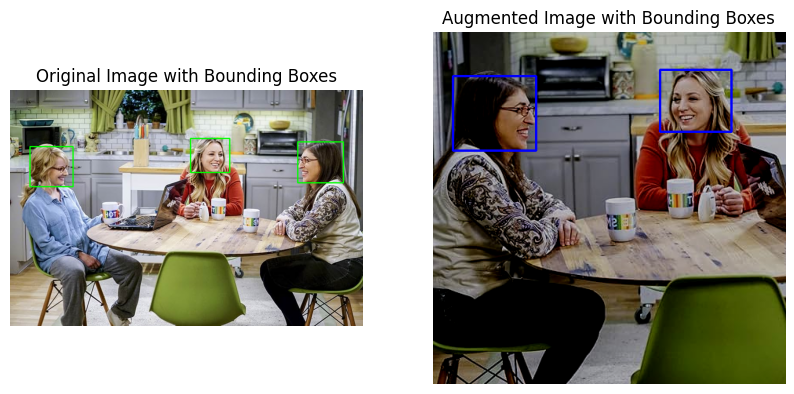

In [8]:
# Test the augmentation process with a random sample
test_augmentation_with_random_sample(TRAIN_IMAGES_DIR, TRAIN_LABELS_DIR)

In [26]:
# Augmentation pipeline for dataset
def augment_dataset(base_dir, aug_dir, partitions=['train', 'validation', 'test']):
    for partition in partitions:
        image_dir = os.path.join(base_dir, partition, 'images')
        label_dir = os.path.join(base_dir, partition, 'labels')
        aug_image_dir = os.path.join(aug_dir, partition, 'images')
        aug_label_dir = os.path.join(aug_dir, partition, 'labels')

        os.makedirs(aug_image_dir, exist_ok=True)
        os.makedirs(aug_label_dir, exist_ok=True)

        for image in os.listdir(image_dir):
            img_path = os.path.join(image_dir, image)
            img = cv2.imread(img_path)
            h, w, _ = img.shape

            label_path = os.path.join(label_dir, image.replace('.jpg', '.json'))
            bboxes = []
            class_labels = []

            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    label = json.load(f)

                for shape in label['shapes']:
                    points = shape['points']
                    bbox = [points[0][0] / w, points[0][1] / h, points[1][0] / w, points[1][1] / h]
                    bboxes.append(bbox)
                    class_labels.append(shape['label'])

            for x in range(50):  # Generate 50 augmented images per original image
                try:
                    augmented = augmentor(image=img, bboxes=bboxes, class_labels=class_labels)
                    aug_img = augmented['image']
                    aug_bboxes = augmented['bboxes']

                    # Save augmented image
                    aug_img_name = f"{image.split('.')[0]}_{x}.jpg"
                    cv2.imwrite(os.path.join(aug_image_dir, aug_img_name), aug_img)

                    # Save augmented labels
                    annotations = []
                    for bbox, label in zip(aug_bboxes, class_labels):
                        annotations.append({
                            "bbox": bbox,
                            "class": label
                        })
                    annotation_data = {
                        "image": aug_img_name,
                        "annotations": annotations
                    }
                    with open(os.path.join(aug_label_dir, aug_img_name.replace('.jpg', '.json')), 'w') as f:
                        json.dump(annotation_data, f)

                except Exception as e:
                    print(f"Error augmenting image {image}: {e}")

# Run dataset augmentation
augment_dataset("data", "aug_data")


## 5. Loading Images and Labels into the Dataset

### 5.1 Creating functions to load images and labels

In [6]:
# TensorFlow Dataset Loading
def load_image(image_path):
    """Loads an image from a file path."""
    byte_img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(byte_img)
    return img

def load_labels(label_path):
    """Loads labels from a JSON file."""
    with open(label_path.numpy().decode('utf-8'), 'r') as f:
        label_data = json.load(f)

    # Parse bounding boxes and classes
    bboxes = []
    classes = []
    for annotation in label_data['annotations']:
        bboxes.append(annotation['bbox'])
        classes.append(CHARACTER_CLASSES[annotation['class']])  # Map string labels to numeric IDs

    # Pad bounding boxes and classes to a fixed size
    max_boxes = 10  # Assumes a maximum of 10 bounding boxes per image
    bboxes = bboxes + [[0, 0, 0, 0]] * (max_boxes - len(bboxes))
    classes = classes + [0] * (max_boxes - len(classes))

    return tf.convert_to_tensor(classes, dtype=tf.uint8), tf.convert_to_tensor(bboxes, dtype=tf.float32)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [7]:
# Load augmented train dataset
train_images = tf.data.Dataset.list_files(os.path.join(TRAIN_AUG_IMAGES_DIR, '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120, 120)))
train_images = train_images.map(lambda x: x / 255)

In [8]:
# Load augmented validation dataset
validation_images = tf.data.Dataset.list_files(os.path.join(VALIDATION_AUG_IMAGES_DIR, '*.jpg'), shuffle=False)
validation_images = validation_images.map(load_image)
validation_images = validation_images.map(lambda x: tf.image.resize(x, (120, 120)))
validation_images = validation_images.map(lambda x: x / 255)

In [9]:
# Load augmented test dataset
test_images = tf.data.Dataset.list_files(os.path.join(TEST_AUG_IMAGES_DIR, '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120, 120)))
test_images = test_images.map(lambda x: x / 255)

In [10]:
train_images.as_numpy_iterator().next()

array([[[0.00000000e+00, 5.45343151e-03, 0.00000000e+00],
        [1.02941180e-02, 1.02941180e-02, 1.12745101e-02],
        [7.26960778e-01, 7.13051498e-01, 7.62254894e-01],
        ...,
        [5.66482842e-01, 5.31188726e-01, 5.48835814e-01],
        [1.32046565e-01, 1.10968135e-01, 8.89093131e-02],
        [1.05943628e-01, 8.29044133e-02, 5.49632348e-02]],

       [[0.00000000e+00, 4.22794139e-03, 3.06372560e-04],
        [6.49509812e-03, 6.49509812e-03, 0.00000000e+00],
        [3.43137258e-03, 0.00000000e+00, 1.75857842e-02],
        ...,
        [4.78063732e-01, 4.43259805e-01, 4.45710778e-01],
        [9.65686291e-02, 7.54901990e-02, 5.34313731e-02],
        [7.30392188e-02, 4.60784324e-02, 3.43137272e-02]],

       [[0.00000000e+00, 0.00000000e+00, 4.90196096e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [8.00245106e-02, 6.04166649e-02, 4.86519597e-02],
        [1.16115198e-01, 9.65

### 6.2 Load Labels to Tensorflow Dataset

In [11]:
# Load augmented train labels
train_labels = tf.data.Dataset.list_files(os.path.join(TRAIN_AUG_LABELS_DIR, '*.json'), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))

In [12]:
# Load augmented validation labels
validation_labels = tf.data.Dataset.list_files(os.path.join(VALIDATION_AUG_LABELS_DIR, '*.json'), shuffle=False)
validation_labels = validation_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))

In [13]:
# Load augmented test labels
test_labels = tf.data.Dataset.list_files(os.path.join(TEST_AUG_LABELS_DIR, '*.json'), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float32]))

In [14]:
train_labels.as_numpy_iterator().next()

(array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8),
 array([[0.22822754, 0.64164025, 0.42928568, 0.81756616],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        ]], dtype=float32))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [15]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(validation_images), len(validation_labels)

(8700, 8700, 1650, 1650, 1750, 1750)

### 7.2 Create Final Datasets (Images/Labels)

In [16]:
# Combine images and labels into datasets
train = tf.data.Dataset.zip((train_images, train_labels)).shuffle(5000).batch(8).prefetch(tf.data.AUTOTUNE)
validation = tf.data.Dataset.zip((validation_images, validation_labels)).shuffle(1300).batch(8).prefetch(tf.data.AUTOTUNE)
test = tf.data.Dataset.zip((test_images, test_labels)).shuffle(1000).batch(8).prefetch(tf.data.AUTOTUNE)

### 7.3 View Images and Annotations

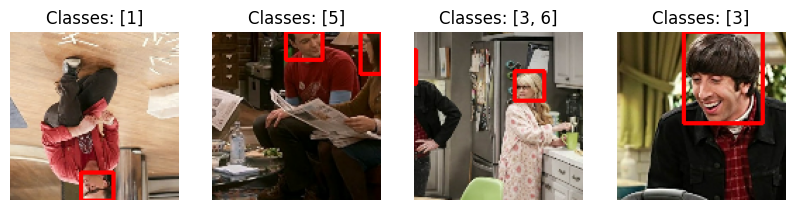

In [31]:
def visualize_random_samples(dataset):
    """Visualizes 4 random samples from a dataset."""
    data_samples = dataset.as_numpy_iterator()
    res = data_samples.next()  # Get a batch

    fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
    for idx in range(4):
        sample_image = res[0][idx]
        sample_classes = res[1][0][idx]  # Classes
        sample_bboxes = res[1][1][idx]  # Bounding boxes

        # Convert image to display format
        img_to_display = (sample_image * 255).astype(np.uint8)

        # Draw bounding boxes
        for bbox, class_id in zip(sample_bboxes, sample_classes):
            if np.array_equal(bbox, [0, 0, 0, 0]):  # Skip padded boxes
                continue
            start_point = (int(bbox[0] * 120), int(bbox[1] * 120))
            end_point = (int(bbox[2] * 120), int(bbox[3] * 120))
            cv2.rectangle(img_to_display, start_point, end_point, (255, 0, 0), 2)

        ax[idx].imshow(img_to_display)
        non_zero_classes = [cls for cls in sample_classes if cls != 0]
        ax[idx].set_title(f"Classes: {non_zero_classes}")
        ax[idx].axis("off")
    plt.show()

# Test updated visualization
visualize_random_samples(train)

# 8. Build Deep Learning using the Functional API

### 8.1 Download VGG16

In [22]:
vgg = VGG16(include_top=False)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [48]:
def build_model(): 
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(7, activation='softmax')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(28, activation='sigmoid')(regress1)  # 4 coordinates for each of the 7 classes
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [49]:
facetracker = build_model()
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_3[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_2 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [50]:
# Load a batch of training data
X, y = train.as_numpy_iterator().next()

In [51]:
# Check the shapes of the tensors
print(f"Shape of X: {X.shape}")
print(f"Shape of y[0] (classes): {y[0].shape}")
print(f"Shape of y[1] (bboxes): {y[1].shape}")

Shape of X: (8, 120, 120, 3)
Shape of y[0] (classes): (8, 10)
Shape of y[1] (bboxes): (8, 10, 4)


In [52]:
# Make predictions using the facetracker model
classes, coords = facetracker.predict(X)

# Check the shapes of the predictions
print(f"Shape of classes: {classes.shape}")
print(f"Shape of coords: {coords.shape}")

1/1 [==============================] - 0s 176ms/step
Shape of classes: (8, 7)
Shape of coords: (8, 28)


# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [37]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [38]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [39]:
def localization_loss(y_true, yhat):
    """
    Computes the localization loss for bounding boxes, handling multiple padded labels.

    Args:
        y_true: Tensor of true bounding boxes (batch_size, max_boxes, 4).
        yhat: Tensor of predicted bounding boxes (batch_size, max_boxes, 4).

    Returns:
        Mean loss across the batch.
    """
    
    # Ensure yhat has the correct shape
    if len(yhat.shape) == 2:
        yhat = tf.expand_dims(yhat, axis=1)
    
    # Compute coordinate differences for the top-left corner
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :, :2] - yhat[:, :, :2]), axis=-1)

    # Compute height and width for true and predicted boxes
    h_true = y_true[:, :, 3] - y_true[:, :, 1]
    w_true = y_true[:, :, 2] - y_true[:, :, 0]

    h_pred = yhat[:, :, 3] - yhat[:, :, 1]
    w_pred = yhat[:, :, 2] - yhat[:, :, 0]

    # Compute size differences
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred), axis=-1)

    # Ensure delta_size has the same shape as delta_coord
    delta_size = tf.expand_dims(delta_size, axis=-1)
    delta_size = tf.tile(delta_size, [1, tf.shape(delta_coord)[1]])

    # Mask to ignore padded boxes (where y_true is [0, 0, 0, 0])
    mask = tf.reduce_any(tf.not_equal(y_true, 0), axis=-1)
    mask = tf.cast(mask, tf.float32)

    # Apply mask and compute mean loss
    loss = delta_coord + delta_size
    masked_loss = tf.reduce_sum(loss * mask, axis=-1) / (tf.reduce_sum(mask, axis=-1) + 1e-6)

    return tf.reduce_mean(masked_loss)

In [53]:
classloss = SparseCategoricalCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [54]:
# Expand and tile coords to match the shape of y[1]
coords_expanded = tf.expand_dims(coords, axis=1)  # Shape: (8, 1, 4)
coords_tiled = tf.tile(coords_expanded, [1, y[1].shape[1], 1])  # Shape: (8, 10, 4)

# Calculate the localization loss
loss = localization_loss(y[1], coords_tiled)
print(f"Localization Loss: {loss.numpy()}")

Localization Loss: 1.9329984188079834


In [57]:
# Calculate the classification loss
# Convert one-hot encoded labels to integer labels, if necessary
if len(y[0].shape) > 1 and y[0].shape[-1] > 1:
    labels = tf.argmax(y[0], axis=-1)
else:
    labels = tf.reshape(y[0], [-1])

loss_value = classloss(labels, classes)

# Print the classification loss
print(f"Classification Loss: {loss_value.numpy()}")

Classification Loss: 2.349954605102539


In [44]:
# Calculate the regression loss
print(f"Regression Loss: {regressloss(y[1], coords_tiled).numpy()}")

Regression Loss: 0.4192190170288086


# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [75]:
# Define the FaceTracker class
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training=True)

            # Use tf.shape to get the shape dynamically
            y_shape = tf.shape(y[0])
            labels = tf.cond(
                tf.logical_and(tf.size(y_shape) > 1, y_shape[-1] > 1),
                lambda: tf.cast(tf.argmax(y[0], axis=-1), tf.int64),
                lambda: tf.cast(tf.reshape(y[0], [-1]), tf.int64)
            )

            batch_classloss = self.closs(labels, classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localizationloss + 0.5 * batch_classloss

            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        self.opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        # Use tf.shape to get the shape dynamically
        y_shape = tf.shape(y[0])
        labels = tf.cond(
            tf.logical_and(tf.size(y_shape) > 1, y_shape[-1] > 1),
            lambda: tf.cast(tf.argmax(y[0], axis=-1), tf.int64),
            lambda: tf.cast(tf.reshape(y[0], [-1]), tf.int64)
        )

        batch_classloss = self.closs(labels, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)


In [76]:
model = FaceTracker(facetracker)

In [77]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [78]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [81]:
hist = model.fit(train, epochs=20, validation_data=validation, callbacks=[tensorboard_callback])

Epoch 1/20
1088/1088 [==============================] - 141s 121ms/step - total_loss: 0.2024 - class_loss: 8.5555e-06 - regress_loss: 0.2024 - val_total_loss: 0.5339 - val_class_loss: 0.6811 - val_regress_loss: 0.1934
Epoch 2/20
1088/1088 [==============================] - 138s 120ms/step - total_loss: 0.2023 - class_loss: 6.1325e-06 - regress_loss: 0.2023 - val_total_loss: 2.9744 - val_class_loss: 5.6614 - val_regress_loss: 0.1437
Epoch 3/20
1088/1088 [==============================] - 138s 120ms/step - total_loss: 0.2022 - class_loss: 5.2653e-06 - regress_loss: 0.2022 - val_total_loss: 2.4257 - val_class_loss: 4.5590 - val_regress_loss: 0.1462
Epoch 4/20
1088/1088 [==============================] - 137s 119ms/step - total_loss: 0.2021 - class_loss: 3.3708e-06 - regress_loss: 0.2021 - val_total_loss: 1.2409 - val_class_loss: 2.0191 - val_regress_loss: 0.2314
Epoch 5/20
1088/1088 [==============================] - 132s 111ms/step - total_loss: 0.2022 - class_loss: 2.6729e-06 - regress_

### 10.3 Plot Performance

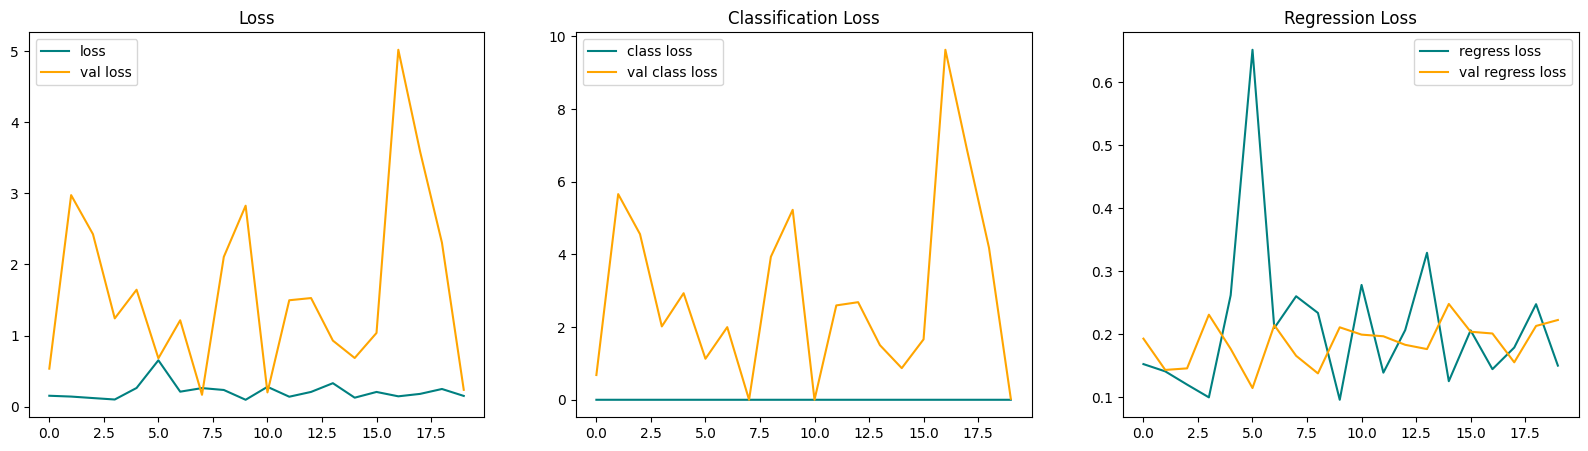

In [82]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [83]:
test_data = test.as_numpy_iterator()

In [84]:
test_sample = test_data.next()

In [85]:
# Visualize the results
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 46ms/step


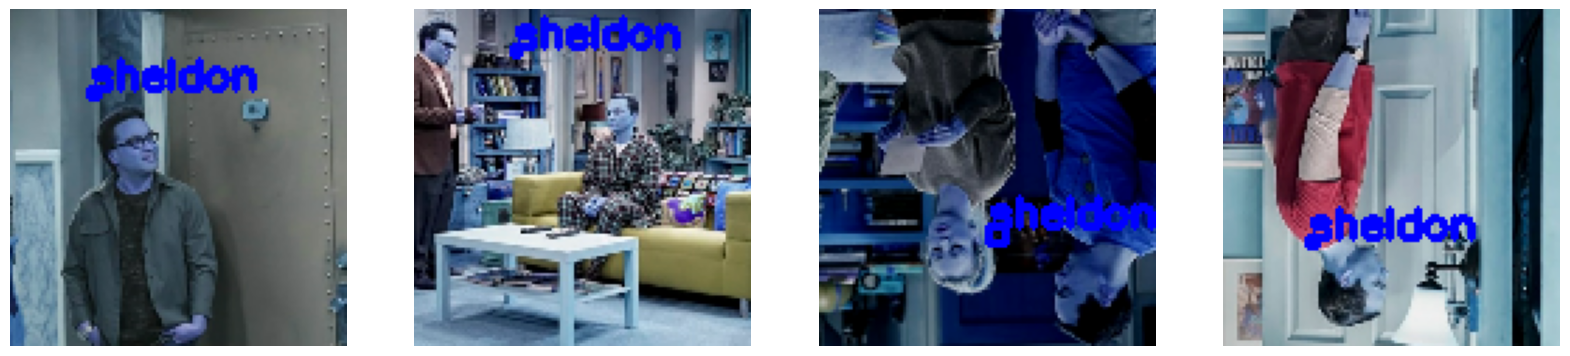

In [95]:
# Visualize the results
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx in range(4):
    sample_image = (test_sample[0][idx] * 255).astype(np.uint8)  # Convert to uint8 for display
    sample_classes = yhat[0][idx]  # Class probabilities
    sample_coords = yhat[1][idx].reshape(-1, 4)  # Reshape to 2D array with 4 columns

    # Draw bounding boxes
    for class_prob, bbox in zip(sample_classes, sample_coords):
        if np.max(class_prob) < 0.5:  # Skip low probability classes
            continue
        start_point = tuple(np.multiply(bbox[:2], sample_image.shape[:2][::-1]).astype(int))
        end_point = tuple(np.multiply(bbox[2:], sample_image.shape[:2][::-1]).astype(int))
        cv2.rectangle(sample_image, start_point, end_point, (255, 0, 0), 2)
        
        # Get the class with the highest probability
        class_id = np.argmax(class_prob)
        character_name = CHARACTER_NAMES.get(class_id, "Unknown")
        cv2.putText(sample_image, character_name, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    ax[idx].imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    ax[idx].axis("off")
plt.show()


### 11.2 Save the Model

In [96]:
from tensorflow.keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [98]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [104]:
# Open the video file
video_path = 'video.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video file opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Function to process each frame
def process_frame(frame):
    # Preprocess the frame (resize and normalize)
    input_frame = cv2.resize(frame, (120, 120))
    input_frame = input_frame / 255.0
    input_frame = np.expand_dims(input_frame, axis=0)

    # Predict using the model
    classes, coords = facetracker.predict(input_frame)

    # Ensure classes and coords have the correct shapes
    if len(classes.shape) == 2 and len(coords.shape) == 2:
        classes = np.expand_dims(classes, axis=0)
        coords = np.expand_dims(coords, axis=0)

    # Draw bounding boxes and character names
    for bbox, class_probs in zip(coords[0], classes[0]):
        class_id = np.argmax(class_probs)
        class_prob = class_probs[class_id]
        if class_prob > 0.7:
            start_point = tuple(np.multiply(bbox[:2], [frame.shape[1], frame.shape[0]]).astype(int))
            end_point = tuple(np.multiply(bbox[2:4], [frame.shape[1], frame.shape[0]]).astype(int))
            cv2.rectangle(frame, start_point, end_point, (255, 0, 0), 2)
            character_name = CHARACTER_NAMES.get(class_id, "Unknown")
            cv2.putText(frame, character_name, start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return frame

# Process the video frame by frame
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process the frame
    processed_frame = process_frame(frame)

    # Display the frame
    cv2.imshow('Video', processed_frame)

    # Exit if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture object and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step
